In [1]:
import pypsa 
import pandas as pd
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!hostname

petunia


# Plots

## Devplan

### Connected - PHS - ERA5

In [3]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_PHS/devplan_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_PHS/devplan_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_PHS/devplan_2030/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units


In [4]:
c=(plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max())
c

(4627.003798497612, 5986.923649034113, 14500.0)

In [5]:
l=(plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max())
l

(11513.7297441, 18044.75917406, 20694.124673360002)

In [6]:
p=(n1.objective/1e9*1e3, n2.objective/1e9*1e3, n3.objective/1e9*1e3)
p

(9.106534784089998, 17.7854687859, 26.9633598708)

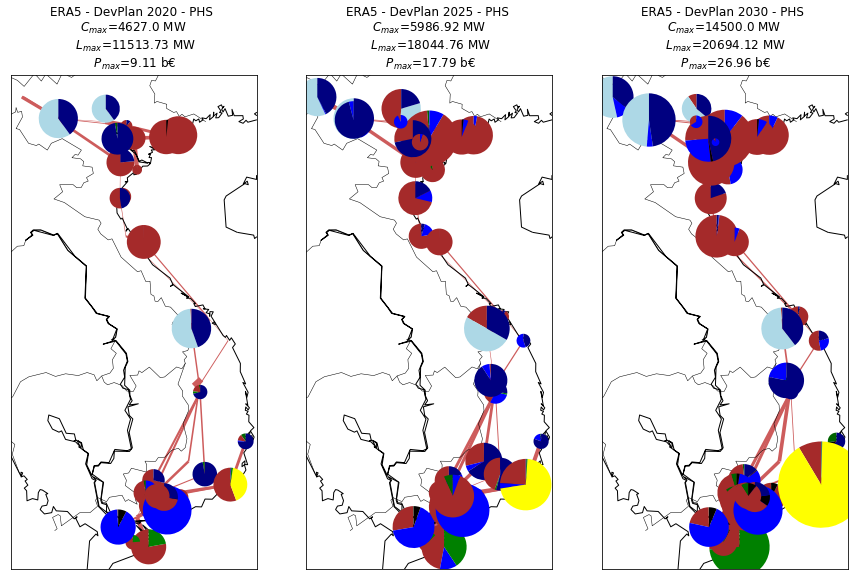

In [7]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum', 'hydro ror'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink', 'lightblue']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan 2020 - PHS \n' + \
                   '$C_{max}$='+str(round(c[0], 2))+' MW \n $L_{max}$='+str(round(l[0], 2))+' MW \n $P_{max}$='+str(round(p[0], 2))+' b€')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan 2025 - PHS \n' + \
                   '$C_{max}$='+str(round(c[1], 2))+' MW \n $L_{max}$='+str(round(l[1], 2))+' MW \n $P_{max}$='+str(round(p[1], 2))+' b€')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan 2030 - PHS \n' + \
                   '$C_{max}$='+str(round(c[2], 2))+' MW \n $L_{max}$='+str(round(l[2], 2))+' MW \n $P_{max}$='+str(round(p[2], 2))+' b€')


fig.savefig(fname='/home/vres/data/ReVietSys/fias-model_era5-data_PHS/plots/era5_PHS_devplan_all.pdf',
            bbox_inches='tight')

### Connected - NO PHS - ERA5

In [8]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data/devplan_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data/devplan_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data/devplan_2030/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units


In [9]:
c=(plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max())
c

(4627.003830690186, 5509.773007541367, 14515.2179851886)

In [10]:
l=(plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max())
l

(11443.18878153, 18068.26500992, 20796.81162774)

In [11]:
p=(n1.objective/1e9*1e3, n2.objective/1e9*1e3, n3.objective/1e9*1e3)
p

(9.12518563714, 17.794664422000004, 26.987890153800002)

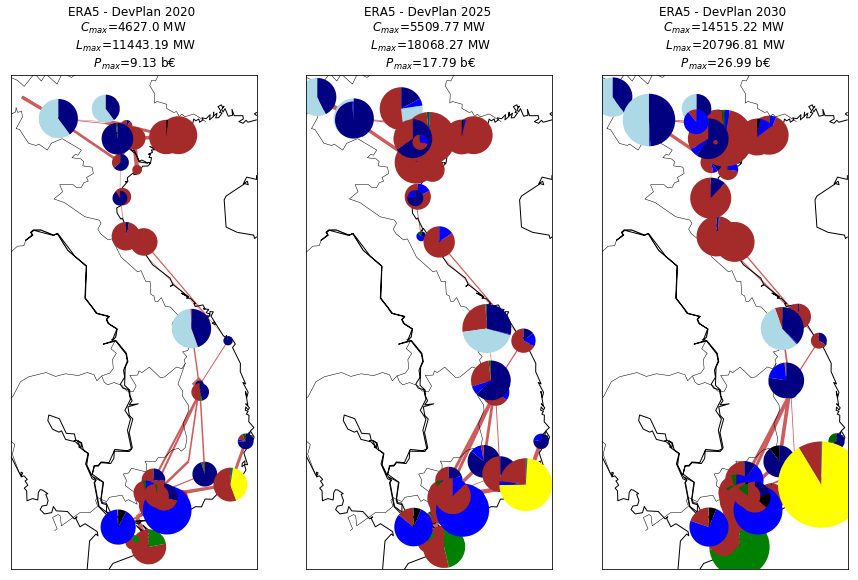

In [12]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum', 'hydro ror'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink', 'lightblue']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan 2020 \n' + \
                   '$C_{max}$='+str(round(c[0], 2))+' MW \n $L_{max}$='+str(round(l[0], 2))+' MW \n $P_{max}$='+str(round(p[0], 2))+' b€')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan 2025 \n' + \
                   '$C_{max}$='+str(round(c[1], 2))+' MW \n $L_{max}$='+str(round(l[1], 2))+' MW \n $P_{max}$='+str(round(p[1], 2))+' b€')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan 2030 \n' + \
                   '$C_{max}$='+str(round(c[2], 2))+' MW \n $L_{max}$='+str(round(l[2], 2))+' MW \n $P_{max}$='+str(round(p[2], 2))+' b€')


fig.savefig(fname='/home/vres/data/ReVietSys/fias-model_era5-data/plots/era5_devplan_all.pdf',
            bbox_inches='tight')

### Connected - PHS - MERRA2

In [13]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_PHS/devplan_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_PHS/devplan_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_PHS/devplan_2030/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units


In [14]:
c=(plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max())
c

(4627.003606883476, 5913.709018237235, 12149.909387799999)

In [15]:
l=(plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max())
l

(11281.209991130001, 17917.022975260003, 20686.09025897)

In [16]:
p=(n1.objective/1e9*1e3, n2.objective/1e9*1e3, n3.objective/1e9*1e3)
p

(9.041407548890001, 17.660699926399996, 26.412357285100004)

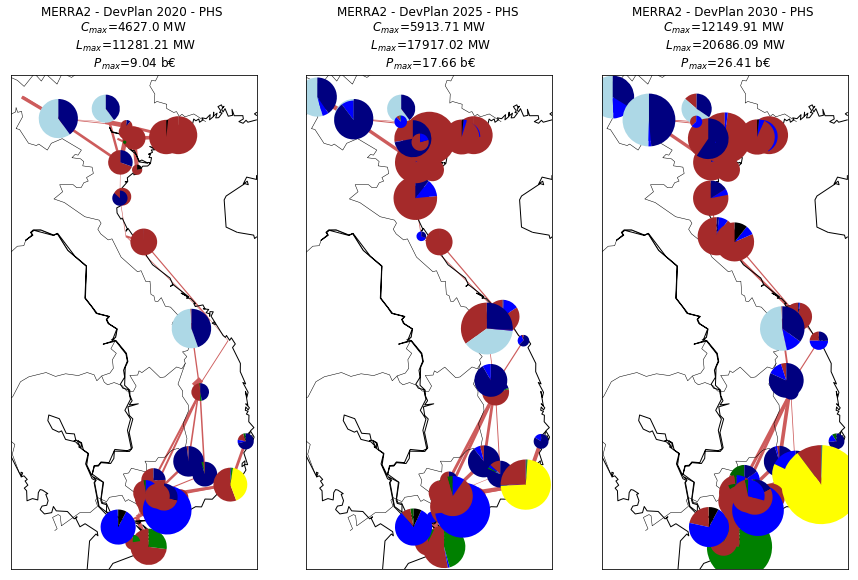

In [17]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum', 'hydro ror'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink', 'lightblue']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - DevPlan 2020 - PHS \n' + \
                   '$C_{max}$='+str(round(c[0], 2))+' MW \n $L_{max}$='+str(round(l[0], 2))+' MW \n $P_{max}$='+str(round(p[0], 2))+' b€')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - DevPlan 2025 - PHS \n' + \
                   '$C_{max}$='+str(round(c[1], 2))+' MW \n $L_{max}$='+str(round(l[1], 2))+' MW \n $P_{max}$='+str(round(p[1], 2))+' b€')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - DevPlan 2030 - PHS \n' + \
                   '$C_{max}$='+str(round(c[2], 2))+' MW \n $L_{max}$='+str(round(l[2], 2))+' MW \n $P_{max}$='+str(round(p[2], 2))+' b€')


fig.savefig(fname='/home/vres/data/ReVietSys/fias-model_ninja-data_PHS/plots/merra2_PHS_devplan_all.pdf',
            bbox_inches='tight')

### Connected - NO PHS - MERRA2

In [18]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data/devplan_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data/devplan_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data/devplan_2030/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units


In [19]:
c=(plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max())
c

(4627.003709636347, 5859.87305187968, 11295.98312521)

In [20]:
l=(plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max())
l

(11235.7814936, 17886.81832256, 20802.164307139996)

In [21]:
p=(n1.objective/1e9*1e3, n2.objective/1e9*1e3, n3.objective/1e9*1e3)
p

(9.059826933230001, 17.668574542800002, 26.4363947576)

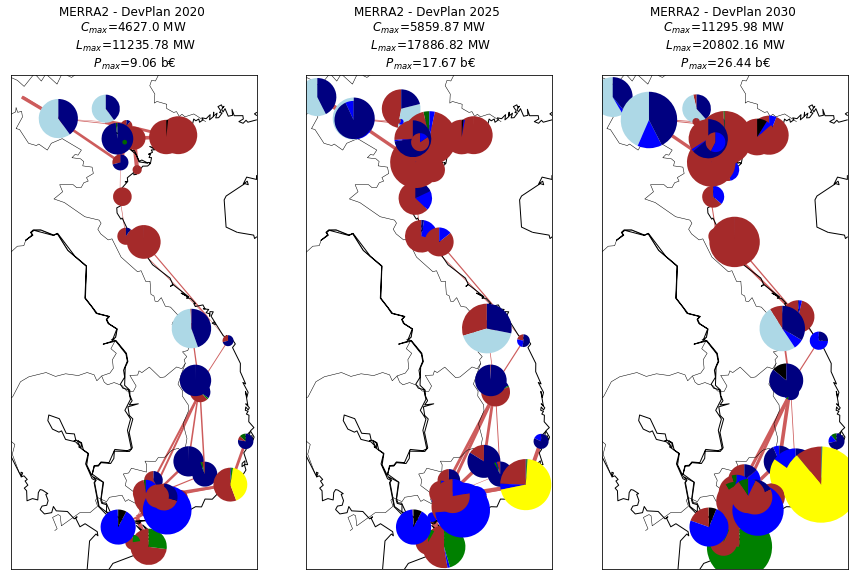

In [22]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum', 'hydro ror'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink', 'lightblue']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - DevPlan 2020 \n' + \
                   '$C_{max}$='+str(round(c[0], 2))+' MW \n $L_{max}$='+str(round(l[0], 2))+' MW \n $P_{max}$='+str(round(p[0], 2))+' b€')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - DevPlan 2025 \n' + \
                   '$C_{max}$='+str(round(c[1], 2))+' MW \n $L_{max}$='+str(round(l[1], 2))+' MW \n $P_{max}$='+str(round(p[1], 2))+' b€')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - DevPlan 2030 \n' + \
                   '$C_{max}$='+str(round(c[2], 2))+' MW \n $L_{max}$='+str(round(l[2], 2))+' MW \n $P_{max}$='+str(round(p[2], 2))+' b€')


fig.savefig(fname='/home/vres/data/ReVietSys/fias-model_ninja-data/plots/merra2_devplan_all.pdf',
            bbox_inches='tight')

## Renewable

### Connected - PHS - ERA5

In [23]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_PHS/renewable_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_PHS/renewable_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_PHS/renewable_2030/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [24]:
c=(plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max())
c

(47505.21956825701, 75100.14407540699, 110259.64509624)

In [25]:
l=(plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max())
l

(33073.493425500004, 51411.534365, 74000.3843955)

In [26]:
p=(n1.objective/1e9*1e3, n2.objective/1e9*1e3, n3.objective/1e9*1e3)
p

(18.2814406992, 30.119813760899998, 46.2885472117)

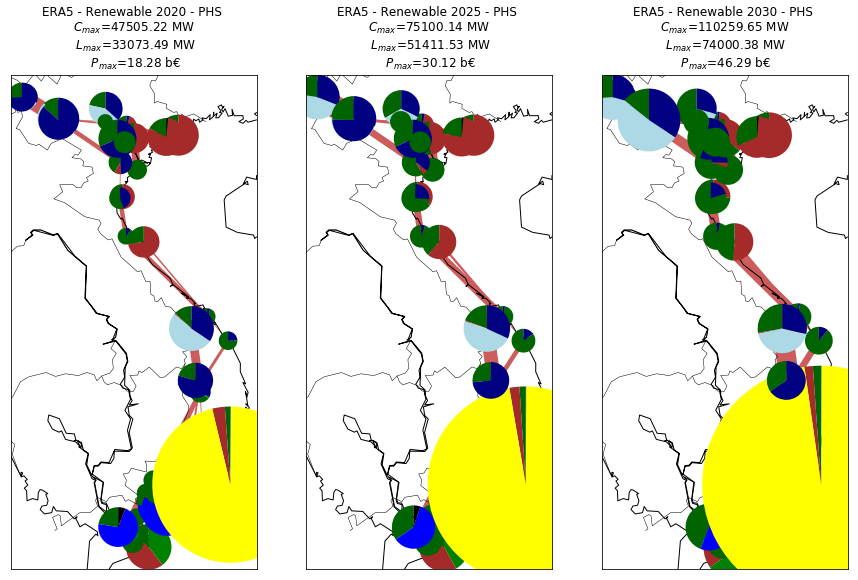

In [27]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum', 'hydro ror'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink', 'lightblue']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable 2020 - PHS \n' + \
                   '$C_{max}$='+str(round(c[0], 2))+' MW \n $L_{max}$='+str(round(l[0], 2))+' MW \n $P_{max}$='+str(round(p[0], 2))+' b€')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable 2025 - PHS \n' + \
                   '$C_{max}$='+str(round(c[1], 2))+' MW \n $L_{max}$='+str(round(l[1], 2))+' MW \n $P_{max}$='+str(round(p[1], 2))+' b€')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable 2030 - PHS \n' + \
                   '$C_{max}$='+str(round(c[2], 2))+' MW \n $L_{max}$='+str(round(l[2], 2))+' MW \n $P_{max}$='+str(round(p[2], 2))+' b€')


fig.savefig(fname='/home/vres/data/ReVietSys/fias-model_era5-data_PHS/plots/era5_PHS_renewable_all.pdf',
            bbox_inches='tight')

### Connected - NO PHS - ERA5

In [28]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data/renewable_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data/renewable_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data/renewable_2030/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [29]:
c=(plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max())
c

(46006.893341967, 73314.163851388, 108618.52329954)

In [30]:
l=(plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max())
l

(31096.7634922, 48186.2135994, 70715.2284624)

In [31]:
p=(n1.objective/1e9*1e3, n2.objective/1e9*1e3, n3.objective/1e9*1e3)
p

(18.5362051327, 30.3606464101, 46.522856103399995)

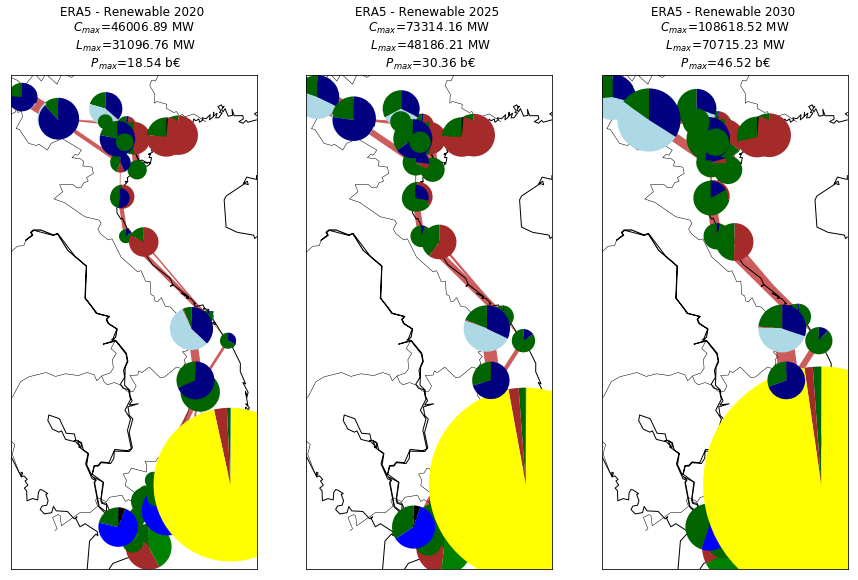

In [32]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum', 'hydro ror'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink', 'lightblue']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable 2020 \n' + \
                   '$C_{max}$='+str(round(c[0], 2))+' MW \n $L_{max}$='+str(round(l[0], 2))+' MW \n $P_{max}$='+str(round(p[0], 2))+' b€')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable 2025 \n' + \
                   '$C_{max}$='+str(round(c[1], 2))+' MW \n $L_{max}$='+str(round(l[1], 2))+' MW \n $P_{max}$='+str(round(p[1], 2))+' b€')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable 2030 \n' + \
                   '$C_{max}$='+str(round(c[2], 2))+' MW \n $L_{max}$='+str(round(l[2], 2))+' MW \n $P_{max}$='+str(round(p[2], 2))+' b€')


fig.savefig(fname='/home/vres/data/ReVietSys/fias-model_era5-data/plots/era5_renewable_all.pdf',
            bbox_inches='tight')

### Connected - PHS - MERRA2

In [33]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_PHS/renewable_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_PHS/renewable_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_PHS/renewable_2030/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [34]:
c=(plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max())
c

(30902.407324625, 50890.664188523, 71098.53432451101)

In [35]:
l=(plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max())
l

(20280.4267748, 34971.3695631, 49745.0137875)

In [36]:
p=(n1.objective/1e9*1e3, n2.objective/1e9*1e3, n3.objective/1e9*1e3)
p

(16.446400070800003, 27.231864454700002, 42.0836452774)

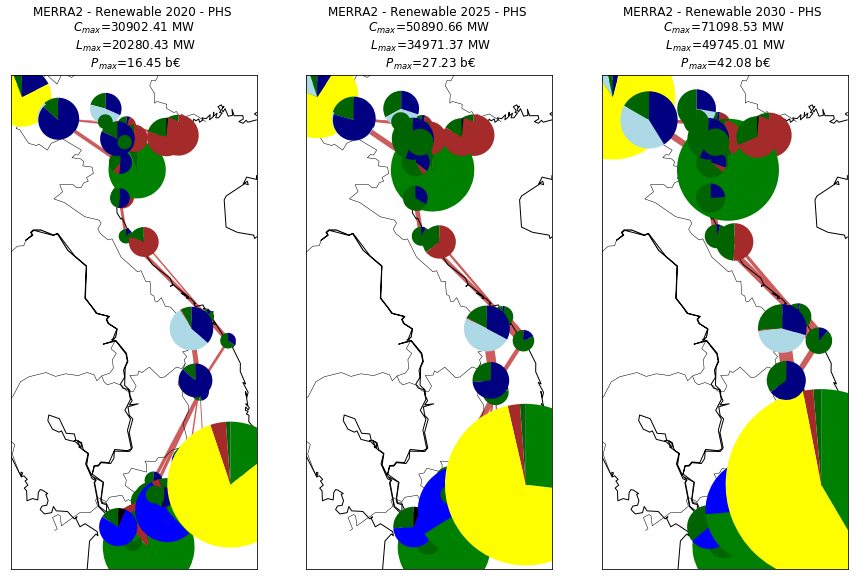

In [37]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum', 'hydro ror'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink', 'lightblue']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - Renewable 2020 - PHS \n' + \
                   '$C_{max}$='+str(round(c[0], 2))+' MW \n $L_{max}$='+str(round(l[0], 2))+' MW \n $P_{max}$='+str(round(p[0], 2))+' b€')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - Renewable 2025 - PHS \n' + \
                   '$C_{max}$='+str(round(c[1], 2))+' MW \n $L_{max}$='+str(round(l[1], 2))+' MW \n $P_{max}$='+str(round(p[1], 2))+' b€')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - Renewable 2030 - PHS \n' + \
                   '$C_{max}$='+str(round(c[2], 2))+' MW \n $L_{max}$='+str(round(l[2], 2))+' MW \n $P_{max}$='+str(round(p[2], 2))+' b€')


fig.savefig(fname='/home/vres/data/ReVietSys/fias-model_ninja-data_PHS/plots/merra2_PHS_renewable_all.pdf',
            bbox_inches='tight')

### Connected - NO PHS - MERRA2

In [38]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data/renewable_2020/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data/renewable_2025/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data/renewable_2030/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas['hydro'] = stores.unstack(level=1)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [39]:
c=(plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max())
c

(32915.795875623, 49157.55264762, 69001.587206781)

In [40]:
l=(plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max())
l

(21647.677418799998, 33322.6349252, 47315.809985800006)

In [41]:
p=(n1.objective/1e9*1e3, n2.objective/1e9*1e3, n3.objective/1e9*1e3)
p

(16.6203737605, 27.420623914500002, 42.18987830099999)

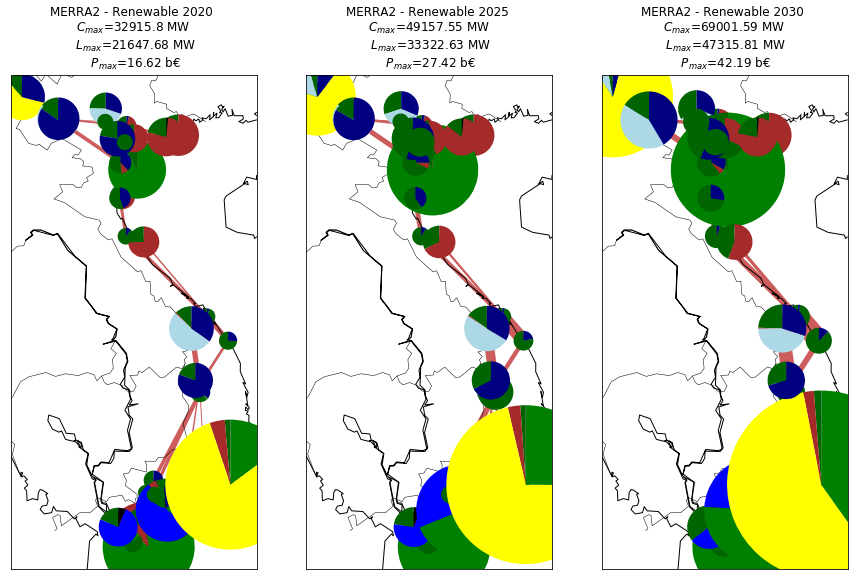

In [42]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum', 'hydro ror'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink', 'lightblue']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - Renewable 2020 \n' + \
                   '$C_{max}$='+str(round(c[0], 2))+' MW \n $L_{max}$='+str(round(l[0], 2))+' MW \n $P_{max}$='+str(round(p[0], 2))+' b€')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - Renewable 2025 \n' + \
                   '$C_{max}$='+str(round(c[1], 2))+' MW \n $L_{max}$='+str(round(l[1], 2))+' MW \n $P_{max}$='+str(round(p[1], 2))+' b€')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - Renewable 2030 \n' + \
                   '$C_{max}$='+str(round(c[2], 2))+' MW \n $L_{max}$='+str(round(l[2], 2))+' MW \n $P_{max}$='+str(round(p[2], 2))+' b€')


fig.savefig(fname='/home/vres/data/ReVietSys/fias-model_ninja-data/plots/merra2_renewable_all.pdf',
            bbox_inches='tight')

# Storage

## ERA5: Devplan + Storage

In [43]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_storage/devplan_2020_storage/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_storage/devplan_2025_storage/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_storage/devplan_2030_storage/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units


In [44]:
plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max()

(4627.003830690186, 5491.944818884785, 14547.983553373)

In [45]:
plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max()

(11443.18878325, 18068.26501219, 20796.811627760002)

In [46]:
n1.objective/1e9, n2.objective/1e9, n3.objective/1e9

(0.00912518563717, 0.0177946644219, 0.0269878901538)

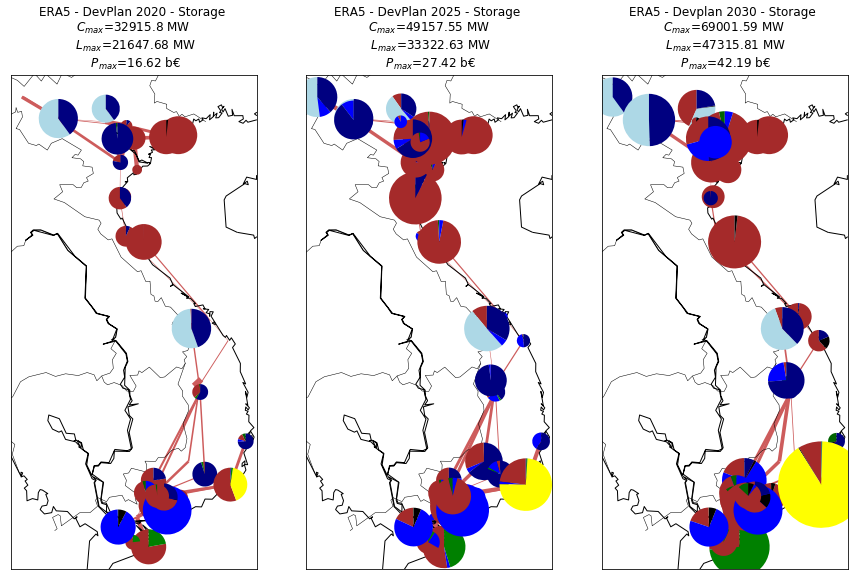

In [47]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum', 'hydro ror', 'battery', 'hydrogen'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink', 'lightblue', 'gold', 'red']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan 2020 - Storage \n' + \
                   '$C_{max}$='+str(round(c[0], 2))+' MW \n $L_{max}$='+str(round(l[0], 2))+' MW \n $P_{max}$='+str(round(p[0], 2))+' b€')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - DevPlan 2025 - Storage \n' + \
                   '$C_{max}$='+str(round(c[1], 2))+' MW \n $L_{max}$='+str(round(l[1], 2))+' MW \n $P_{max}$='+str(round(p[1], 2))+' b€')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Devplan 2030 - Storage \n' + \
                   '$C_{max}$='+str(round(c[2], 2))+' MW \n $L_{max}$='+str(round(l[2], 2))+' MW \n $P_{max}$='+str(round(p[2], 2))+' b€')


fig.savefig(fname='/home/vres/data/ReVietSys/fias-model_era5-data_storage/plots/era5_storage_devplan_all.pdf',
            bbox_inches='tight')

## ERA5: Renewable + Storage

In [48]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_storage/renewable_2020_storage/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_storage/renewable_2025_storage/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_era5-data_storage/renewable_2030_storage/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [49]:
c=(plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max())
c

(56548.056070256, 78277.14796142899, 97559.546997673)

In [50]:
l=(plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max())
l

(30786.964425, 38119.4122397, 46456.0715806)

In [51]:
p=(n1.objective/1e9*1e3, n2.objective/1e9*1e3, n3.objective/1e9*1e3)
p

(18.0703553719, 29.5725983135, 45.3719936689)

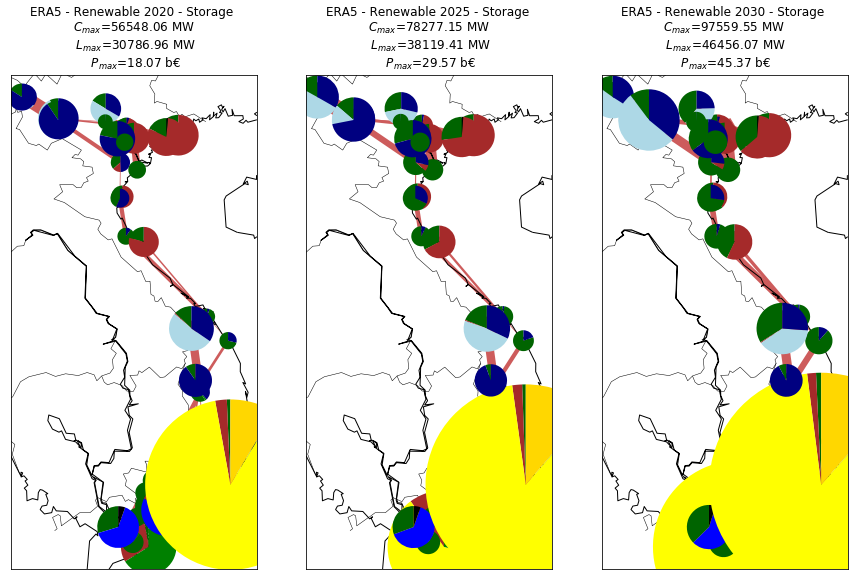

In [52]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum', 'hydro ror', 'battery', 'hydrogen'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink', 'lightblue', 'gold', 'red']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable 2020 - Storage \n' + \
                   '$C_{max}$='+str(round(c[0], 2))+' MW \n $L_{max}$='+str(round(l[0], 2))+' MW \n $P_{max}$='+str(round(p[0], 2))+' b€')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable 2025 - Storage \n' + \
                   '$C_{max}$='+str(round(c[1], 2))+' MW \n $L_{max}$='+str(round(l[1], 2))+' MW \n $P_{max}$='+str(round(p[1], 2))+' b€')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='ERA5 - Renewable 2030 - Storage \n' + \
                   '$C_{max}$='+str(round(c[2], 2))+' MW \n $L_{max}$='+str(round(l[2], 2))+' MW \n $P_{max}$='+str(round(p[2], 2))+' b€')


fig.savefig(fname='/home/vres/data/ReVietSys/fias-model_era5-data_storage/plots/era5_storage_renewable_all.pdf',
            bbox_inches='tight')

## MERRA2: Devplan + Storage

In [53]:
n1 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_storage/devplan_2020_storage/')
n2 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_storage/devplan_2025_storage/')
n3 = pypsa.Network('/home/vres/data/ReVietSys/fias-model_ninja-data_storage/devplan_2030_storage/')

#%%
capas = n1.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n1.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n1.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas1 = capas
plotlines1 = lines

capas = n2.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n2.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n2.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas2 = capas
plotlines2 = lines

capas = n3.generators.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
stores = n3.storage_units.groupby(['bus','carrier']).p_nom_opt.mean().fillna(0.)
lines = n3.lines.groupby(['bus0', 'bus1']).s_nom_opt.mean().fillna(0.)
capas = capas.loc[capas.index.levels[0][capas.groupby(level='bus').sum()!=0],:]
capas = capas.unstack(level=1)
capas= capas.assign(hydro=stores.unstack(level=1).hydro,
                    hydrogen=stores.unstack(level=1).hydrogen,
                    battery=stores.unstack(level=1).battery)
capas = capas.stack(level=0)
plotcapas3 = capas
plotlines3 = lines

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, carriers, generators, lines, loads, storage_units


In [54]:
c=(plotcapas1.sum(level=0).max(), plotcapas2.sum(level=0).max(), plotcapas3.sum(level=0).max())
c

(4627.003709636347, 6164.157121449822, 11295.98312521)

In [55]:
l=(plotlines1.sum(level=0).max(), plotlines2.sum(level=0).max(), plotlines3.sum(level=0).max())
l

(11235.78149306, 17886.81832663, 20802.170140320002)

In [56]:
p=(n1.objective/1e9*1e3, n2.objective/1e9*1e3, n3.objective/1e9*1e3)
p

(9.05982693299, 17.6685745429, 26.436394757899997)

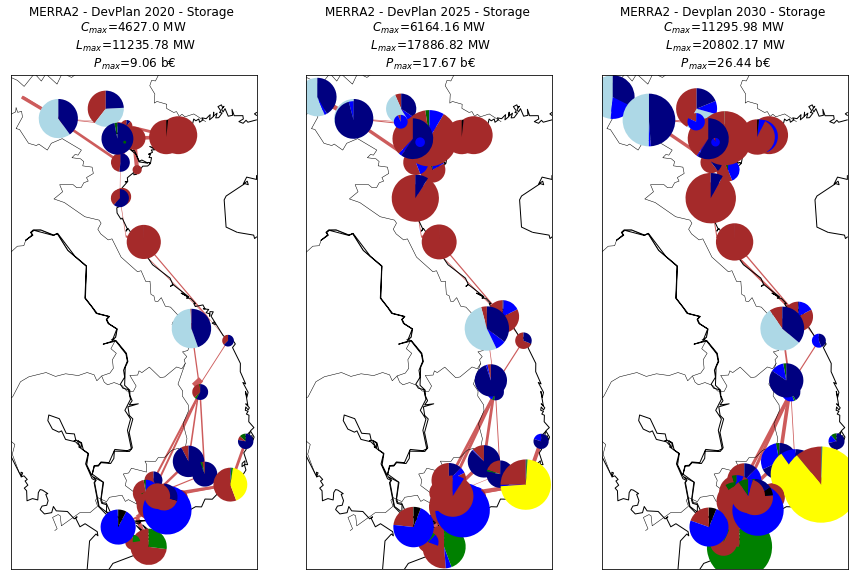

In [57]:
colors = dict(zip(['ocgt', 'wind', 'solar', 'hydro', 'hard coal', 'oil', 'bioenergy', 'nuclear', 'perpetuum', 'hydro ror', 'battery', 'hydrogen'],
                  ['blue', 'green', 'yellow', 'navy', 'brown', 'black', 'darkgreen', 'lime', 'pink', 'lightblue', 'gold', 'red']))

bus_scale = 1e4
link_scale = 1e3

fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(15,15))
n1.plot(bus_sizes=plotcapas1/bus_scale, bus_colors=colors, ax=ax1,
             line_widths={'Link':0.0, 'Line':plotlines1/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - DevPlan 2020 - Storage \n' + \
                   '$C_{max}$='+str(round(c[0], 2))+' MW \n $L_{max}$='+str(round(l[0], 2))+' MW \n $P_{max}$='+str(round(p[0], 2))+' b€')
n2.plot(bus_sizes=plotcapas2/bus_scale, bus_colors=colors, ax=ax2,
             line_widths={'Link':0.0, 'Line':plotlines2/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - DevPlan 2025 - Storage \n' + \
                   '$C_{max}$='+str(round(c[1], 2))+' MW \n $L_{max}$='+str(round(l[1], 2))+' MW \n $P_{max}$='+str(round(p[1], 2))+' b€')
n3.plot(bus_sizes=plotcapas3/bus_scale, bus_colors=colors, ax=ax3,
             line_widths={'Link':0.0, 'Line':plotlines3/link_scale},
             line_colors={'Link':'purple', 'Line':'indianred'},
             title='MERRA2 - Devplan 2030 - Storage \n' + \
                   '$C_{max}$='+str(round(c[2], 2))+' MW \n $L_{max}$='+str(round(l[2], 2))+' MW \n $P_{max}$='+str(round(p[2], 2))+' b€')


fig.savefig(fname='/home/vres/data/ReVietSys/fias-model_ninja-data_storage/plots/merra2_storage_devplan_all.pdf',
            bbox_inches='tight')

## MERRA5: Renewable + Storage

# N/A

# Model Information

/home/schlott/FRESNA/PyPSA/pypsa/plot.py:199: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  np.arange(len(index)))))


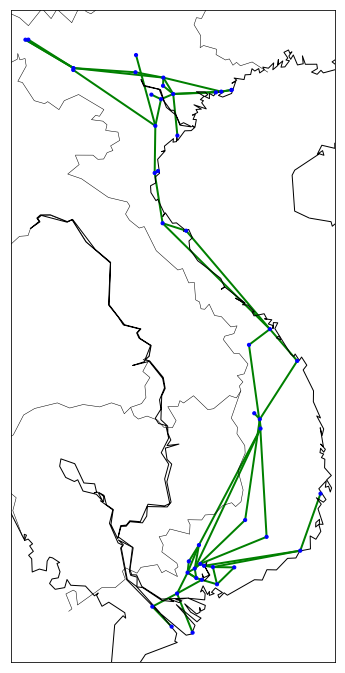

In [68]:
fig, ax = plt.subplots(0, figsize=(12,12))
n1.plot()
plt.savefig(fname='/home/schlott/vietnam/results/network_topoloy.pdf', bbox_inches='tight')

In [77]:
scenarios = pd.read_csv('/home/schlott/vietnam/ReVietSys/scenario_limits.csv')
scenarios = scenarios.set_index(scenarios['scenario']).drop(columns='scenario').dropna(axis=1)

In [78]:
scenarios

,wind,solar,hydro_old,bioenergy,hard coal,oil,ocgt,nuclear,total_capacities,load_increase,generation_increase,renewable_share,nuclear_old,hydro ror,hydro
scenario,,,,,,,,,,,,,,,
2020,800,850,21600,306,26000,1065,9000,0,60000,1.787,1.826,0.070,0,4849.91,16750.09
2025,2000,4000,24600,559,47600,1775,15000,0,96500,2.722,2.776,0.085,0,7849.91,16750.09
2030,6000,12000,27800,1407,55300,2248,19000,0,129500,3.965,3.996,0.100,4600,11049.91,16750.09


In [82]:
scenarios.to_excel('/home/schlott/vietnam/results/model_information.xls')